# Feature Engineering

In [68]:
# distance to nearest metra station
# distance to nearest Divvy station
# distance to nearest grocery store
# number of grocery stores within 10 minute walk

In [11]:
import pandas as pd
import numpy as np
import os
import yaml
import requests
import geopy.distance
from EDA import map_functions
from sklearn.neighbors import KNeighborsClassifier
from walk_score import get_walk_score_from_coord

In [10]:
# config variables
ROOT = "C:/Users/Beau/Documents/GitHub/RealEstate"
SERIALIZED = os.path.join(ROOT, "data", "serialized")
CLEANED = os.path.join(ROOT, "data", "processed")
WALK_DISTANCE = 0.5

In [73]:
# read in datasets
# TODO: reset the index in the EDA files
# df_permits = pd.read_pickle(os.path.join(CLEANED, "Building_Permits.pkl")).reset_index()
# df_licenses = pd.read_pickle(os.path.join(CLEANED, "Business_Licenses.pkl")).reset_index()
# df_licenses = pd.read_pickle(os.path.join(CLEANED, "Business_Licenses_Current.pkl")).reset_index()
# df_licenses_liq = pd.read_pickle(os.path.join(DATA_DIR, "Business_Licenses_-_Current_Liquor_and_Public_Places_of_Amusement_Licenses.pkl")).reset_index()
# TODO: check if this is just a subset of the df_licenses
# df_crimes = pd.read_pickle(os.path.join(DATA_DIR, "Crimes_-_2001_to_Present.pkl")).reset_index()
df_grocery = pd.read_pickle(os.path.join(CLEANED, "Grocery.pkl")).reset_index()
# WARNING: df_grocery is slightly out of date (last updated 2020 I think?)
# df_landmarks = pd.read_pickle(os.path.join(CLEANED, "Individual_Landmarks.pkl")).reset_index()
df_murals = pd.read_pickle(os.path.join(CLEANED, "Murals.pkl")).reset_index()
df_art = pd.read_pickle(os.path.join(CLEANED, "Park_Art.pkl")).reset_index()
df_L = pd.read_pickle(os.path.join(CLEANED, "L_Stations.pkl")).reset_index()
df_Divvy = pd.read_pickle(os.path.join(CLEANED, "Divvy_Stations.pkl")).reset_index()
# TODO: population density from census
# TODO: employment growth from census?

# df_sold = pd.read_pickle(os.path.join(CLEANED, "Redfin_multifamily_sold_in_2022.pkl")).reset_index()
df_sold = pd.read_pickle(
    os.path.join(CLEANED, "input_features_walkscores.pkl")
).reset_index()

### walk scores

walk score has 13 amenity categories:

grocery stores, coffee shops, restaurants, bars, movie theatres, schools, parks, libraries, book stores, fitness centres, drug stores, hardware stores, clothing/music stores

In [44]:
# # read in walk score api key
# with open(os.path.join(ROOT, "credentials.yml"), mode="r") as file:
#     wskey = yaml.safe_load(file)['walk-score-key']

# for idx, row in df_sold.iterrows():
#     df_sold.loc[idx, ["WALK_SCORE", "TRANSIT_SCORE", "BIKE_SCORE"]] = get_walk_score_from_coord(row.LATITUDE, row.LONGITUDE, wskey)

# df_sold.to_pickle(os.path.join(CLEANED, "input_features_walkscores.pkl"))

In [74]:
df_sold

,level_0,index,SOLD DATE,PROPERTY TYPE,ADDRESS,ZIP OR POSTAL CODE,PRICE,BEDS,BATHS,LOCATION,...,YEAR BUILT,URL (SEE https://www.redfin.com/buy-a-home/comparative-market-analysis FOR INFO ON PRICING),LATITUDE,LONGITUDE,SOLD_YEAR,SOLD_MONTH,SOLD_DAY,WALK_SCORE,TRANSIT_SCORE,BIKE_SCORE
0,0,0,2022-12-21,Multi-Family (2-4 Unit),1921 S Miller St,60608,270000,6.0,2.0,CHI - Lower West Side,...,1875.0,https://www.redfin.com/IL/Chicago/1921-S-Mille...,41.856006,-87.652159,2022,December,21,94.0,NaN,93.0
1,1,1,2022-12-16,Multi-Family (2-4 Unit),2853 S Farrell St,60608,200000,6.0,2.0,CHI - Bridgeport,...,1885.0,https://www.redfin.com/IL/Chicago/2853-S-Farre...,41.841814,-87.653778,2022,December,16,83.0,NaN,84.0
2,2,2,2022-12-16,Multi-Family (5+ Unit),3329 S Lituanica Ave,60608,200000,4.0,3.5,NaN,...,1888.0,https://www.redfin.com/IL/Chicago/3329-S-Litua...,41.833931,-87.648267,2022,December,16,92.0,NaN,88.0
3,3,3,2022-12-16,Multi-Family (2-4 Unit),3248 S Paulina St,60608,250000,6.0,2.0,NaN,...,1875.0,https://www.redfin.com/IL/Chicago/3248-S-Pauli...,41.834686,-87.668265,2022,December,16,79.0,NaN,62.0
4,4,4,2022-12-16,Multi-Family (5+ Unit),510 W Root St,60609,65000,6.0,4.0,NaN,...,1876.0,https://www.redfin.com/IL/Chicago/510-W-Root-S...,41.819241,-87.639081,2022,December,16,76.0,NaN,59.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2455,2455,2455,2022-01-19,Multi-Family (2-4 Unit),3555 N Ashland Ave,60657,1230000,4.0,3.5,NaN,...,1886.0,https://www.redfin.com/IL/Chicago/3555-N-Ashla...,41.946776,-87.668459,2022,January,19,96.0,NaN,86.0
2456,2456,2456,2022-01-19,Multi-Family (2-4 Unit),2049 W Augusta Blvd,60622,1200000,6.0,3.0,NaN,...,1910.0,https://www.redfin.com/IL/Chicago/2049-W-Augus...,41.899322,-87.679103,2022,January,19,95.0,NaN,98.0
2457,2457,2457,2022-01-03,Multi-Family (2-4 Unit),1127 W George St,60657,1160000,8.0,5.0,CHI - Lake View,...,NaN,https://www.redfin.com/IL/Chicago/1127-W-Georg...,41.934173,-87.657594,2022,January,3,92.0,NaN,86.0
2458,2458,2458,2022-01-03,Multi-Family (5+ Unit),3824 N Bell Ave,60618,1175000,7.0,3.0,NaN,...,1901.0,https://www.redfin.com/IL/Chicago/3824-N-Bell-...,41.951217,-87.685011,2022,January,3,80.0,NaN,82.0


<AxesSubplot:>

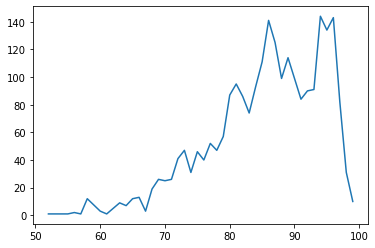

In [75]:
df_sold.WALK_SCORE.value_counts().sort_index().plot()

In [76]:
# TODO: why does transit score not work?
print(df_sold.TRANSIT_SCORE.notnull().sum())

0


In [77]:
# use nearest neighbors model to impute the year built
knn = KNeighborsClassifier(n_neighbors=5)
missing_idx = df_sold["YEAR BUILT"].isnull()
X_present = df_sold.loc[~missing_idx, ["LATITUDE", "LONGITUDE"]]
X_missing = df_sold.loc[missing_idx, ["LATITUDE", "LONGITUDE"]]
y_present = df_sold.loc[~missing_idx, "YEAR BUILT"]
y_missing = df_sold.loc[missing_idx, "YEAR BUILT"]

knn.fit(X_present, y_present)

imputations = pd.Series(
    knn.predict(X_missing), index=X_missing.index, name="imputations"
)

df_sold.loc[df_sold["YEAR BUILT"].isnull(), "YEAR BUILT"] = imputations

In [78]:
# get closest distance metrics
# df_sold["min_dist_to_grocery"] = map_functions.get_closest(df_sold.LATITUDE, df_sold.LONGITUDE, df_grocery.LATITUDE, df_grocery.LONGITUDE)
# df_sold["min_dist_to_landmark"] = map_functions.get_closest(df_sold.LATITUDE, df_sold.LONGITUDE, df_landmarks.LATITUDE, df_landmarks.LONGITUDE)
# df_sold["min_dist_to_mural"] = map_functions.get_closest(df_sold.LATITUDE, df_sold.LONGITUDE, df_murals.LATITUDE, df_murals.LONGITUDE)
# df_sold["min_dist_to_art"] = map_functions.get_closest(df_sold.LATITUDE, df_sold.LONGITUDE, df_art.LATITUDE, df_art.LONGITUDE)
df_sold["min_dist_to_L"] = map_functions.get_closest(
    df_sold.LATITUDE, df_sold.LONGITUDE, df_L.LATITUDE, df_L.LONGITUDE
)
df_sold["min_dist_to_Divvy"] = map_functions.get_closest(
    df_sold.LATITUDE, df_sold.LONGITUDE, df_Divvy.LATITUDE, df_Divvy.LONGITUDE
)

In [62]:
# get count within distance metrics
# TODO: change distance for permits, licenses?
# TODO: need to filter out permits, licesnses because there are way too many
# df_sold[f"count_permits_{WALK_DISTANCE}_mi"] = map_functions.count_points_within_range(df_sold.LATITUDE, df_sold.LONGITUDE, df_permits.LATITUDE, df_permits.LONGITUDE, WALK_DISTANCE)
# df_sold[f"count_licenses_{WALK_DISTANCE}_mi"] = map_functions.count_points_within_range(df_sold.LATITUDE, df_sold.LONGITUDE, df_licenses.LATITUDE, df_licenses.LONGITUDE, WALK_DISTANCE)
# df_sold[f"count_grocery_{WALK_DISTANCE}_mi"] = map_functions.count_points_within_range(df_sold.LATITUDE, df_sold.LONGITUDE, df_grocery.LATITUDE, df_grocery.LONGITUDE, WALK_DISTANCE)
# df_sold[f"count_landmarks_{WALK_DISTANCE}_mi"] = map_functions.count_points_within_range(df_sold.LATITUDE, df_sold.LONGITUDE, df_landmarks.LATITUDE, df_landmarks.LONGITUDE, WALK_DISTANCE)
# df_sold[f"count_murals_{WALK_DISTANCE}_mi"] = map_functions.count_points_within_range(df_sold.LATITUDE, df_sold.LONGITUDE, df_murals.LATITUDE, df_murals.LONGITUDE, WALK_DISTANCE)
# df_sold[f"count_art_{WALK_DISTANCE}_mi"] = map_functions.count_points_within_range(df_sold.LATITUDE, df_sold.LONGITUDE, df_art.LATITUDE, df_art.LONGITUDE, WALK_DISTANCE)
# df_sold[f"count_L_{WALK_DISTANCE}_mi"] = map_functions.count_points_within_range(df_sold.LATITUDE, df_sold.LONGITUDE, df_L.LATITUDE, df_L.LONGITUDE, WALK_DISTANCE)
# df_sold[f"count_L_{WALK_DISTANCE}_mi"] = map_functions.count_points_within_range(df_sold.LATITUDE, df_sold.LONGITUDE, df_Divvy.LATITUDE, df_Divvy.LONGITUDE, WALK_DISTANCE)

In [79]:
df_sold.to_pickle(os.path.join(CLEANED, "input_features.pkl"))